In [1]:
# Miscellaneous imports
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()


For uniform results, random seed is required

In [2]:
tf.random.set_seed(100)
np.random.seed(100)

Here I am setting a dtype policy of 'mixed_float16'. Why? Because it speeds up training without sacrificing the quality of the model.

Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory. By keeping certain parts of the model in the 32-bit types for numeric stability, the model will have a lower step time and train equally as well in terms of the evaluation metrics such as accuracy.

In [3]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 1. Exploring dataset

In [4]:
!pip install split-folders

In [5]:
#split the dataset into train, test and validation
import splitfolders
path = '/kaggle/input/covid-tb-pneumonia/covid_tb_pneumonia_ds'
splitfolders.ratio(path, output = 'cxr_data', ratio = (0.70,0.15,0.15), seed = 42)

Copying files: 18781 files [01:12, 258.52 files/s]


In [6]:

# Put them to a dataframe
data_directories = ['/kaggle/working/cxr_data/train/','/kaggle/working/cxr_data/test/','/kaggle/working/cxr_data/val/']
all_paths = []
all_labels = []
for data_dir in data_directories:
    for label in os.listdir(data_dir):
        for image in os.listdir(data_dir+label):
            all_paths.append(data_dir+label+'/'+image)
            all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':all_paths, 'label':all_labels})
df

,path,label
0,/kaggle/working/cxr_data/train/Normal/Normal-3763.png,Normal
1,/kaggle/working/cxr_data/train/Pneumonia/person1526_bacteria_3986.jpeg,Pneumonia
2,/kaggle/working/cxr_data/train/Covid-19/COVID-3461.png,Covid-19
3,/kaggle/working/cxr_data/train/Normal/Normal-5298.png,Normal
4,/kaggle/working/cxr_data/val/Covid-19/COVID-1070.png,Covid-19
...,...,...
18776,/kaggle/working/cxr_data/val/Covid-19/COVID-3039.png,Covid-19
18777,/kaggle/working/cxr_data/train/Covid-19/COVID-1756.png,Covid-19
18778,/kaggle/working/cxr_data/train/Pneumonia/person154_virus_305.jpeg,Pneumonia
18779,/kaggle/working/cxr_data/test/Normal/Normal-5407.png,Normal


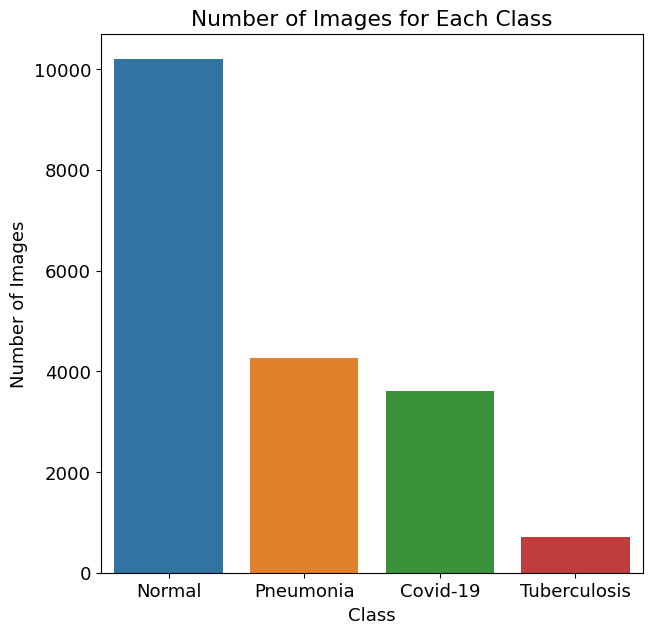

In [7]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Class')
plt.show()

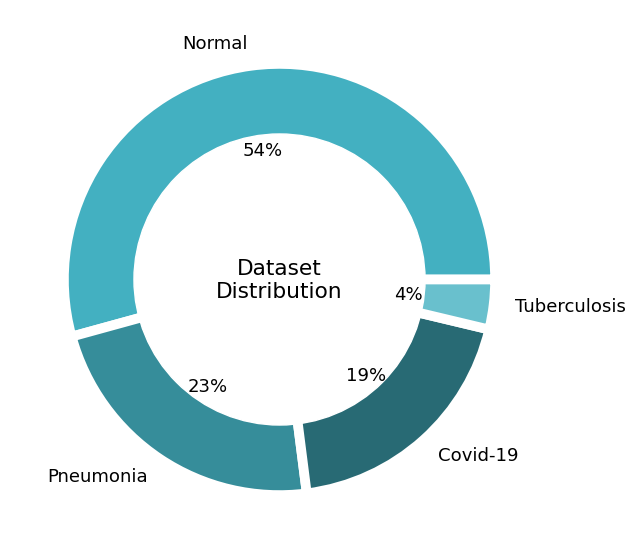

In [8]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
# plotting data on chart
plt.pie(list(df.label.value_counts()),
        labels=list(df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Dataset\nDistribution', x=0.5, y=0.45) 
plt.show()

# 2. Pre-processing
Image Augmentation is a process that is used to create new images for training by slightly altering the pixel values.
We have a small dataset, so we can apply some image augmentation techniques to prevent overfitting of the model.
Techniques we will be using are:

1. Change the brightness of an image by a factor between 0.67 to 1.33
2. Change the contrast of an image by a factor between 0.67 to 1.33

### Configuration settings

In [9]:
class cfg:
    IMAGE_SIZE = 224

    # Data Augmentation
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST   = (0.64, 1.37) # (MIN, MAX)
    # Train-Val Split
    TRAIN_VAL_SPLIT = 0.8 # 80% of all the samples are used for training, and the rest for validation
    # Model Training
    BATCH_SIZE = 32
    EPOCHS = 15
    LEARNING_RATE = 0.001

In [12]:
def augment_image(image):
    # Convert input image from numpy to PIL Image
    image = Image.fromarray(np.uint8(image)) 
    # Select brightness and contrast factors
    brightness_factor = random.uniform(cfg.BRIGHTNESS[0],cfg.BRIGHTNESS[1])
    contrast_factor = random.uniform(cfg.CONTRAST[0],cfg.CONTRAST[1])
    # Apply Transformations
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    
    return image

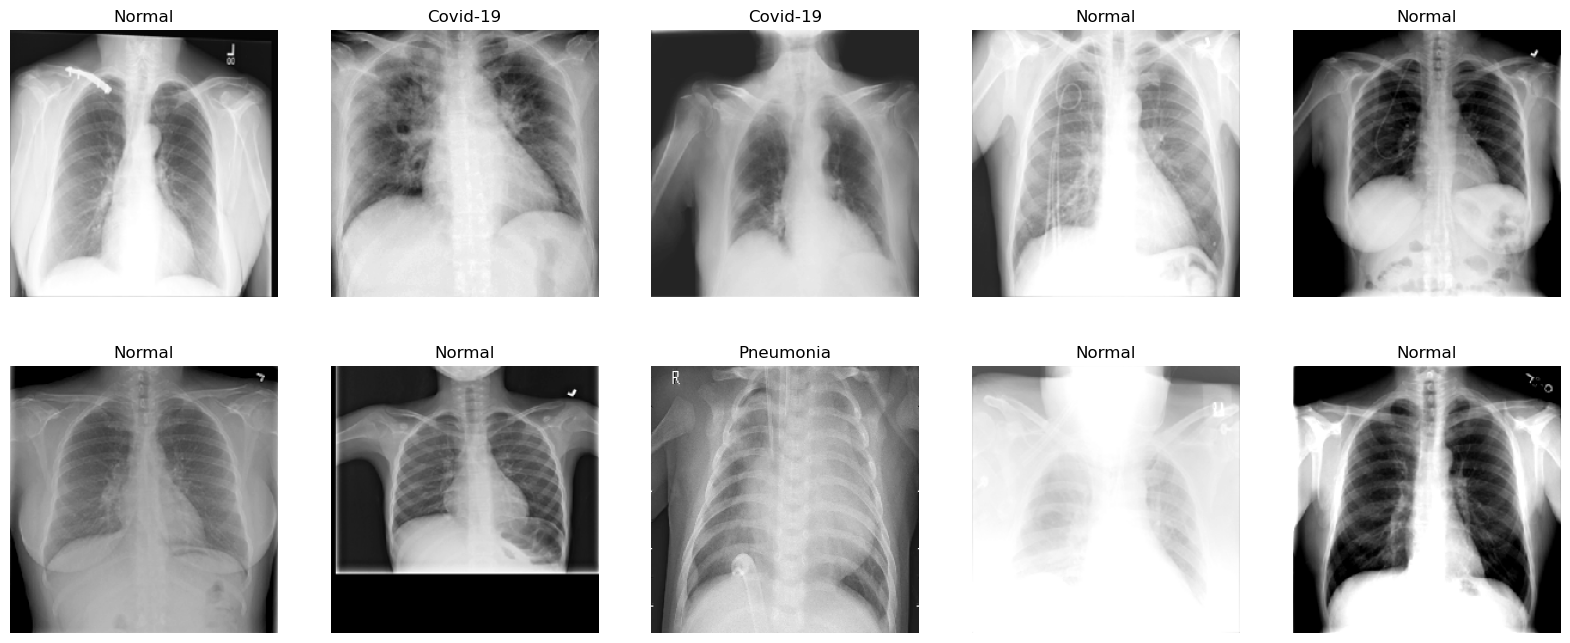

In [13]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(cfg.IMAGE_SIZE,cfg.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(df.path[k:k+10])
labels = list(df.label[k:k+10])
images = open_images(image_paths, augment=True)
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

## 2.1 Label encoder-decoder
1. Creating a dictionary label_encoder to convert string label to interger-encoded label
2. And another dictionary label_decoder to decode the integer-encoded label

In [14]:
LABELS = ['Normal', 'Tuberculosis', 'Pneumonia', 'Covid-19']
label_encoder = {'Normal': 0, 'Tuberculosis': 1, 'Pneumonia': 2, 'Covid-19': 3}
label_decoder = {0: 'Normal', 1: 'Tuberculosis', 2: 'Pneumonia', 3: 'Covid-19'}

# 2.2 Train-val split

>  Here I am splitting the dataset, 80% for training & 20% for validation

In [15]:
df_train = df[:int(cfg.TRAIN_VAL_SPLIT*len(df))]
df_val = df[int(cfg.TRAIN_VAL_SPLIT*len(df)):]

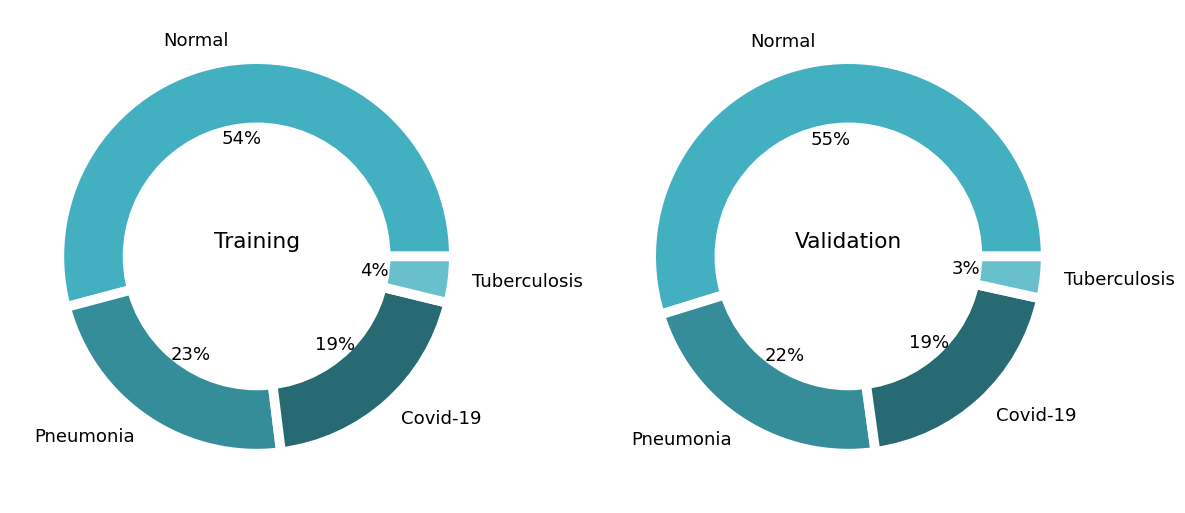

In [16]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 2, 1)
plt.pie(list(df_train.label.value_counts()),
        labels=list(df_train.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 2, 2)
plt.pie(list(df_val.label.value_counts()),
        labels=list(df_val.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

plt.show()

Training a model on this highly imbalanced dataset will cause the model to overfit on the class that is in excess and fail to learn patterns from other classes. Fortunately, there are ways to tackle this problem. What we will be doing is assigning "class weights" to the classes, to handle the imbalanced classes. This will be computed in the later sections

## 2.3 Data Generators
data_generator is the generator function which we will use for training. It has 4 input parameters:

1. > df: This is the dataframe containing the image paths and labels \n
1. > batch_size (int): Batch size of training samples
1. > augment (boolean): If true, the augmentation techniques defined before will be applied to the images. We will set this to True during training and False during validation
1. > epochs (int): Number of epochs

In [17]:
def data_generator(df, batch_size=cfg.BATCH_SIZE, augment=True, epochs=cfg.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [18]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(df_train, batch_size=cfg.BATCH_SIZE, augment=True, epochs=cfg.EPOCHS)
train_steps = int(len(df_train)/cfg.BATCH_SIZE)

val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE, augment=False, epochs=cfg.EPOCHS)
val_steps = int(len(df_val)/cfg.BATCH_SIZE)

# 3. Model

## 3.1 Model architecture 
* We are utilizing the inspiration of ResNet-50 model

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add

In [20]:
resnet_model= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
for layer in resnet_model.layers[:-10]:
    layers.trainable=False
hm = resnet_model.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)

model = Model(inputs=resnet_model.input, outputs = hm)

94765736/94765736 [==============================] - 4s 0us/step


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## 3.2 Compile

This is the loss function we will be using:  

$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [y_i\text{log}(\hat y_i) + (1-y_i)\text{log}(1-\hat y_i)]$$
where,  
$\quad\hat y$ is the predicted label, and $y$ is the actual label  
$\quad y_i$ is the $i^\mathbf{th}$ sample of $y$  and $\hat y_i$ is the $i^\mathbf{th}$ sample of $\hat y$  
$\quad N$ is the number of samples

`sparse_categorical_crossentropy` and `categorical_crossentropy` are basically the same loss functions, just their input formats are different.  
If $y_i$ is <b><mark>one-hot encoded</mark></b>, we use `categorical_crossentropy`, and if $y_i$ is <b><mark>integer-encoded</mark></b>, we use `sparse_categorical_crossentropy`  
For our case, the labels from the data generators are <b><mark>integer-encoded</mark></b>, so we are using `sparse_categorical_crossentropy`  

In [22]:
class_weights = (df_train.label.value_counts() / len(df_train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{0: 0.5414004259850905,
 2: 0.22836794462193824,
 3: 0.19222577209797656,
 1: 0.03800585729499468}

In [23]:
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(cfg.LEARNING_RATE)
model.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
#            loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

# 3.3 Training the model
As said earlier, we will be using 'class weights' to tackle the imbalanced dataset problem. Using the cross-entropy loss function will create a bias towards the dominating class. So, we will apply multipliers, or 'weights' to balance the loss function. This is called a <b><mark>weighted loss function</mark></b>:  
$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [w_p y_i\text{log}(\hat y_i) + w_n (1-y_i)\text{log}(1-\hat y_i)]$$

So how do you calculate these so called weights $w_p$ and $w_n$ for each class? Just calculate the proportion of the dataset each class represents and tensorflow will handle the rest.  
`class_weights` is a dictionary of format `{'CLASS':'PROPORTION'}`

In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history = model.fit(train_data_generator, epochs=cfg.EPOCHS, steps_per_epoch=train_steps, class_weight=class_weights,
          validation_data=val_data_generator, validation_steps=val_steps, callbacks=[model_checkpoint_callback])

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.6426
Epoch 1: val_accuracy improved from -inf to 0.54754, saving model to /kaggle/working/model.hdf5
469/469 [==============================] - 159s 287ms/step - loss: 0.2327 - accuracy: 0.6426 - val_loss: 1.1545 - val_accuracy: 0.5475
Epoch 2/15
469/469 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.7655
Epoch 2: val_accuracy improved from 0.54754 to 0.71047, saving model to /kaggle/working/model.hdf5
469/469 [==============================] - 129s 272ms/step - loss: 0.1354 - accuracy: 0.7655 - val_loss: 0.8139 - val_accuracy: 0.7105
Epoch 3/15
469/469 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.8186
Epoch 3: val_accuracy improved from 0.71047 to 0.84856, saving model to /kaggle/working/model.hdf5
469/469 [==============================] - 119s 255ms/step - loss: 0.1002 - accuracy: 0.8186 - val_loss: 0.4457 - val_accuracy: 0.8486
Epoch 4/15
46

# 4. Evaluate the model

In [25]:
val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(df_val)/cfg.BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

    Covid-19     0.9179    0.8750    0.8959       728
      Normal     0.9345    0.9908    0.9618      2058
   Pneumonia     0.9928    0.9893    0.9911       842
Tuberculosis     1.0000    0.3256    0.4912       129

    accuracy                         0.9452      3757
   macro avg     0.9613    0.7952    0.8350      3757
weighted avg     0.9466    0.9452    0.9394      3757



# 5. Conclusion and Deployment

1/1 [==============================] - 0s 407ms/step


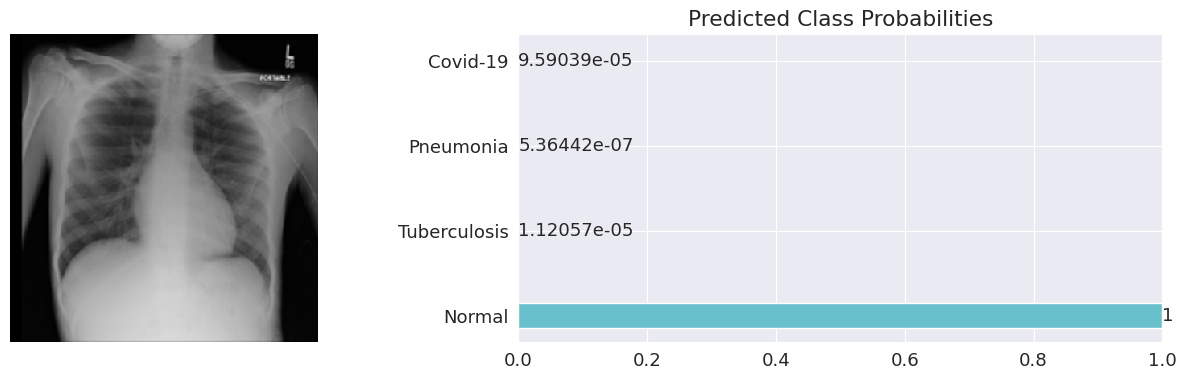

Actual   : Normal
Predicted: Normal
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


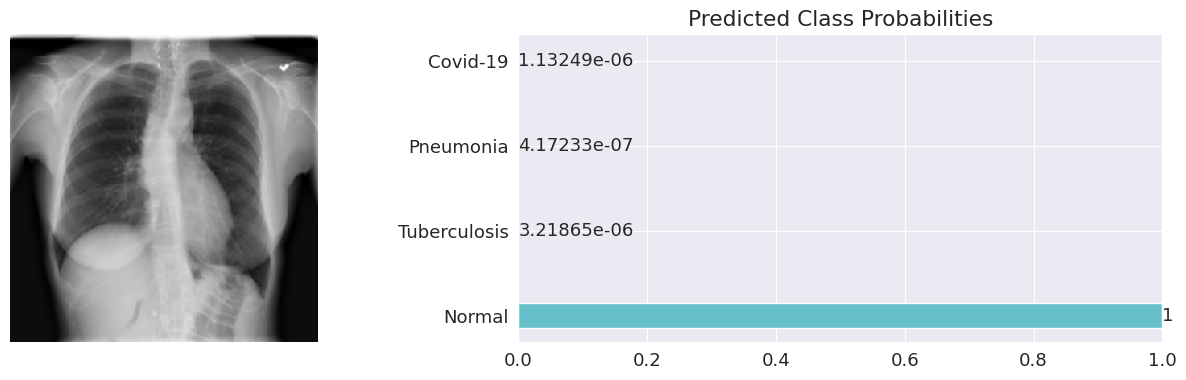

Actual   : Normal
Predicted: Normal
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


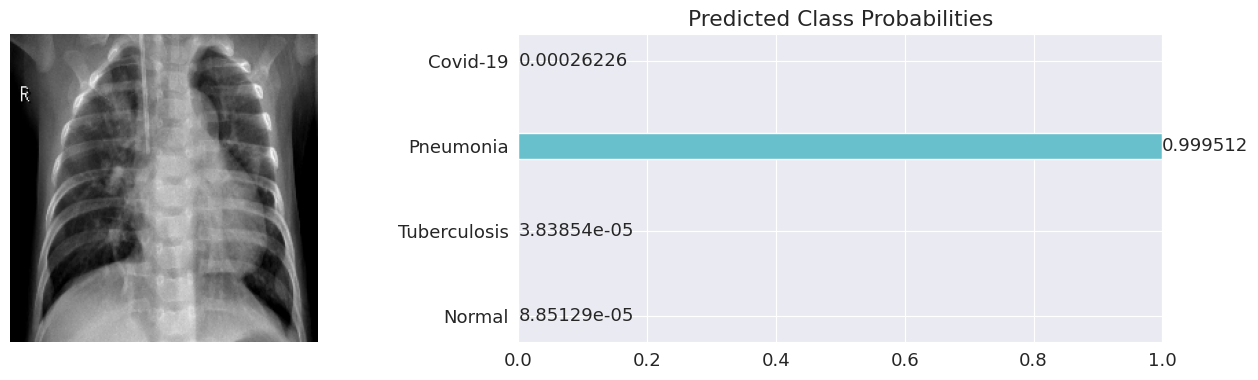

Actual   : Pneumonia
Predicted: Pneumonia
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 25ms/step


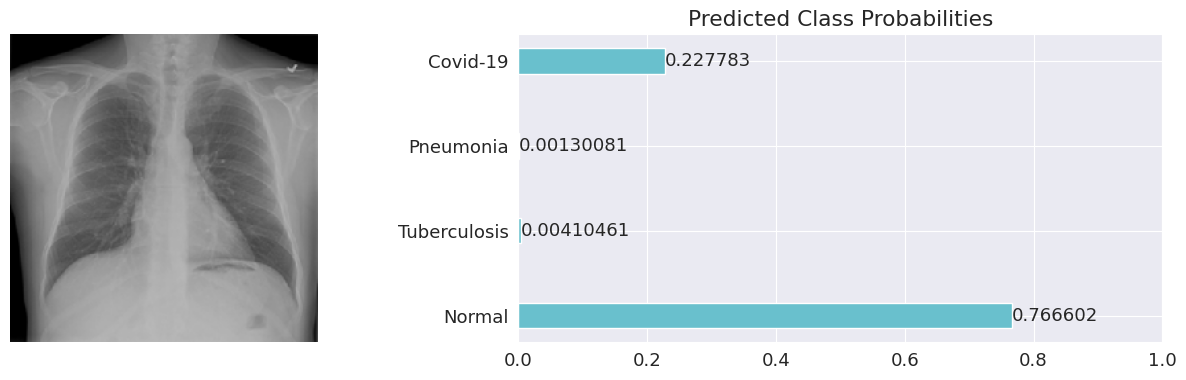

Actual   : Normal
Predicted: Normal
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 27ms/step


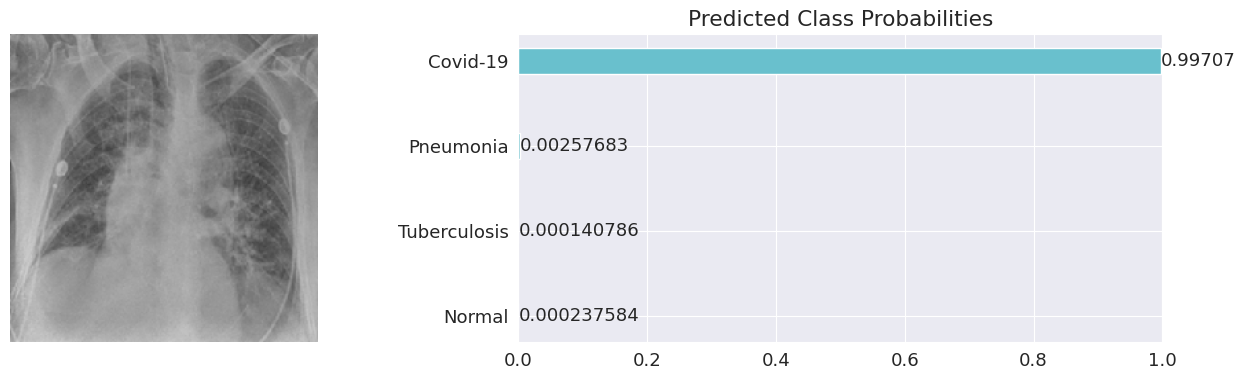

Actual   : Covid-19
Predicted: Covid-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


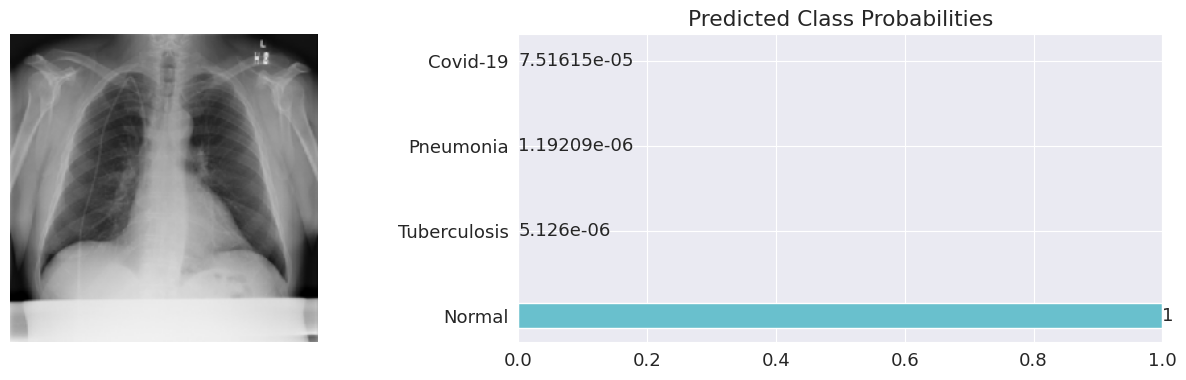

Actual   : Normal
Predicted: Normal
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


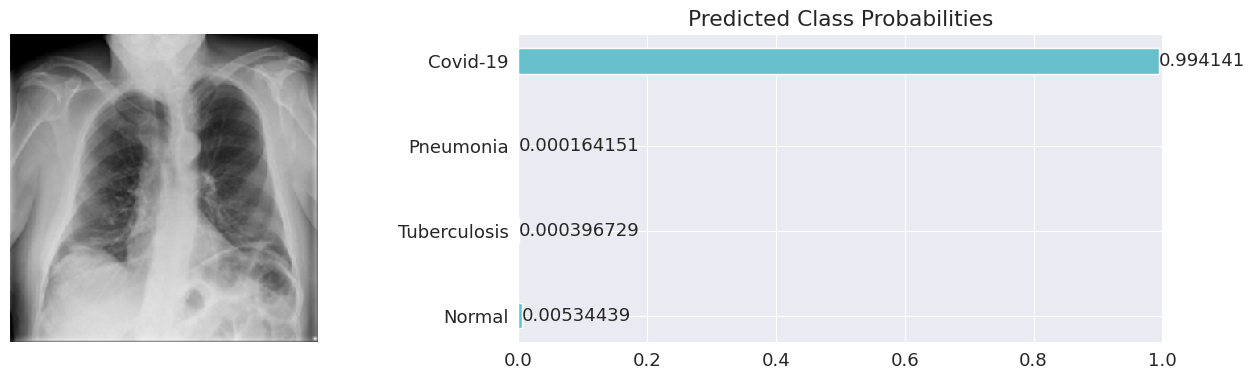

Actual   : Covid-19
Predicted: Covid-19
--------------------------------------------------------------------------------




In [26]:
def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels = ['Normal', 'Tuberculosis', 'Pneumonia', 'Covid-19']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,cfg.IMAGE_SIZE,cfg.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(df.index), 7)

for INDEX in INDICES:

    image = load_img(df.path[INDEX], target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)
    
    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')

**Accuracy plot**

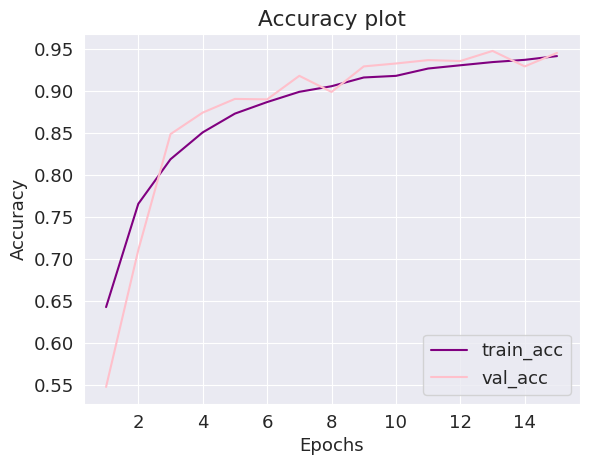

In [27]:
epochs = range (1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], color = 'purple')
plt.plot(epochs, history.history['val_accuracy'], color = 'pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend(["train_acc","val_acc"])
plt.show()

**Loss plots**

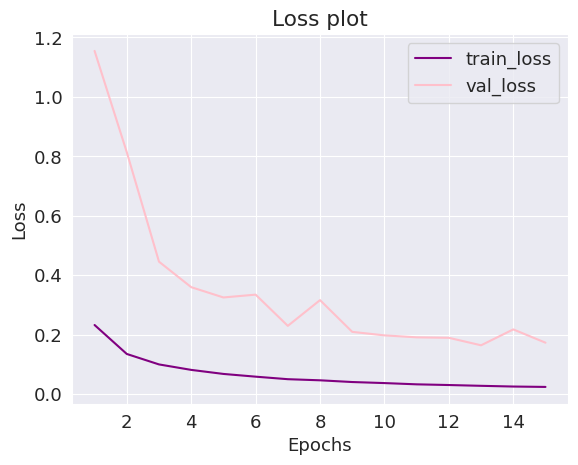

In [28]:
plt.plot(epochs, history.history['loss'], color = 'purple')
plt.plot(epochs, history.history['val_loss'], color = 'pink')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.legend(["train_loss","val_loss"])
plt.show()